In [1]:
import os

import pickle

import numpy as np

import pandas as pd

from tqdm.notebook import tqdm

from PIL import Image

import requests

from io import BytesIO

import matplotlib.pyplot as plt

import tensorflow

from tensorflow import keras

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Model, load_model

from tensorflow.keras.utils import to_categorical, plot_model

from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add, Flatten


from transformers import BertTokenizer, BertModel

import json

In [2]:
print(tensorflow.__version__)

2.16.1


In [3]:
BASE_DIR = '/kaggle/input/dataset'

WORKING_DIR = '/kaggle/working/'

In [ ]:
!pip install ultralytics==8.3.44


In [5]:
from ultralytics import YOLO 

from ultralytics.nn.tasks import DetectionModel

from ultralytics.nn.tasks import attempt_load_one_weight

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [6]:
import tensorflow as tf

import torch

from tensorflow.keras.preprocessing.image import load_img, img_to_array



image = load_img("/kaggle/input/people/z5954204166284_efdac6ee53fc23f3dd6fed41f218096f.jpg", target_size=(640, 640))

image_array = img_to_array(image)

image_array = image_array.reshape((1, image_array.shape[2], image_array.shape[0], image_array.shape[1]))

print(image_array.shape)

image_tensor = torch.from_numpy(image_array)

print(image_array.shape)

(1, 3, 640, 640)
(1, 3, 640, 640)


In [7]:
import torch

import cv2

from torchvision import transforms

from ultralytics import YOLO



# Hàm tiền xử lý ảnh thành tensor cho YOLO

def preprocess_image(image):

    preprocess = transforms.Compose([

        transforms.ToPILImage(),  # Chuyển từ numpy sang PIL

        transforms.Resize((640, 640)),  # Thay đổi kích thước ảnh về 640x640

        transforms.ToTensor(),  # Chuyển thành tensor

        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Chuẩn hóa theo chuẩn của ImageNet

    ])

    tensor_image = preprocess(image).unsqueeze(0)  # Thêm batch dimension

    return tensor_image

In [8]:
import torch

from ultralytics import YOLO



# Load the YOLOv8 model

model = YOLO('yolov8n.pt')



# Access the backbone layers

backbone = model.model.model[:10]  # Layers 0 to 9 form the backbone



# Create a new Sequential model with just the backbone layers

backbone_model = torch.nn.Sequential(*backbone)

100%|██████████| 6.25M/6.25M [00:00<00:00, 82.9MB/s]


In [9]:
# If you want to use the backbone for feature extraction

def extract_features(image):

    with torch.no_grad():

        features = backbone_model(image)

    return features

In [10]:
import pandas as pd 
df = pd.read_csv('/kaggle/input/crawl-data-api-10k-rows/data/captions.csv')
df

,image_id,caption
0,000000000009.jpg,a variety of food items organized in colorful ...
1,000000000025.jpg,two giraffes one standing upright and reaching...
2,000000000030.jpg,a vase with a classical design featuring a flu...
3,000000000034.jpg,a zebra in a grassy field or meadow grazing or...
4,000000000036.jpg,a woman wearing a floral swimsuit standing in ...
...,...,...
9995,000000060576.jpg,an airplane with canadian north branding on it...
9996,000000060593.jpg,two men seated at a restaurant table with one ...
9997,000000060596.jpg,a man lying on a bed with three pillows holdin...
9998,000000060599.jpg,a rural setting with a cow and a horse near a ...


In [11]:
 # load features from pickle

with open(os.path.join('/kaggle/input/yolov8-lstm-imagecaption-encode-10000k/10k_image_features.pkl'), 'rb') as f:

  features = pickle.load(f)

In [12]:
features['000000000009.jpg'].size()

torch.Size([1, 256, 20, 20])

In [13]:
captions_doc = ""

for caption in df['caption']:

    captions_doc += caption + "\n"  # Thêm dấu xuống dòng giữa các caption nếu cần

In [14]:
def clean(mapping, start_end_token = True):

        for key, captions in mapping.items():

            for i in range(len(captions)):

                # take one caption at a time

                caption = captions[i]

                # preprocessing steps

                # convert to lowercase

                caption = caption.lower()

                # delete digits, special  chars, etc, ..

                caption = caption.replace('[^A-Za-z]', '')

                # delete additional spaces

                caption = caption.replace('\s+', ' ')

                if start_end_token == True:

                    # add start and end tags to the caption

                    caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'

                captions[i] = caption

        return mapping

In [15]:
# create mapping of image to captions

mapping = {}

# process lines

for index, row in tqdm(df.iterrows(), total=df.shape[0]):

  image_id = row['image_id']

  caption = row['caption']

  # remove extension from image ID

  image_id = image_id.split('.')[0]

  # create list if needed

  if image_id not in mapping:

    mapping[image_id] = []

  # store the caption

  mapping[image_id].append(caption)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [16]:
clean(mapping)

{'000000000009': ['startseq variety of food items organized in colorful containers the main objects in the image include bread broccoli oranges pineapples almonds cookies butter meatballs and possibly few others there are six colorful containers in the image each containing different food items fruits in the picture include oranges and pineapples there are multiple pieces of bread and the broccoli is placed in yellow container the meatball is located below the broccoli in the same yellow container the cookies are round with textured surface possibly indicating chocolate chip cookies there is butter in one of the containers the meal appears to be lunch or dinner meal combining main items like bread and meatballs with side items such as fruits vegetables and treat cookie the use of separate containers suggests it might be packed or onthego meal possibly bentostyle lunch box endseq'],
 '000000000025': ['startseq two giraffes one standing upright and reaching for the branches of tree while

In [17]:
# after preprocess of text
mapping['000000000036']

['startseq woman wearing floral swimsuit standing in front of signboard with an unreadable text holding pink umbrella in her hand and wearing headband she is standing in front of body of water with few distant swimmers or objects visible the mood of the image is joyful and carefree with blue sky and summery atmosphere endseq']

In [18]:
all_captions = []

for key in mapping:
  for caption in mapping[key]:
    all_captions.append(caption)

In [19]:
# tokenize the text
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenized_caption = tokenizer(all_captions, return_tensors='pt', padding=True, truncation=True)
vocab_size = tokenizer.vocab_size

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [20]:
vocab_size

30522

In [21]:
# get maximum length of the caption available

max_length = max(len(caption.split()) for caption in all_captions)

max_length

299

# Split - train - test - val 

In [22]:
SAVE_CHECKPOINT_DIR = WORKING_DIR

In [23]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.utils import to_categorical

import numpy as np

def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):

    X1, X2, y = list(), list(), list()

    n = 0

    while True:
        for key in data_keys:
            n += 1
            caption = mapping[key]  # lấy caption trực tiếp từ mapping với key

            # Encode the sequence using BertTokenizer

            encoded = tokenizer(caption, return_tensors='pt', padding=True, truncation=True, max_length=max_length) # Ensure padding and truncation are done correctly

            seq = encoded['input_ids'][0]  # Lấy input_ids từ tokenizer

            # Convert input_ids và attention_mask thành numpy arrays

            seq = np.array(seq)

            
            # split the sequence into X, y pairs

            for i in range(1, len(seq)):

                # split into input and output pairs

                in_seq, out_seq = seq[:i], seq[i]

                # pad input sequence

                in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post') [0] # Pad sequences at the end

                # encode output sequence

                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                # store the sequences

                # feature_key = 'http://images.cocodataset.' + key + '.jpg'
                feature_key = key + '.jpg'

                X1.append(features[feature_key][0])

                X2.append(in_seq)

                y.append(out_seq)


            if n == batch_size:

                X1, X2, y = np.array(X1), np.array(X2), np.array(y)

                yield (X1, X2), y

                X1, X2, y = list(), list(), list()

                n = 0

In [24]:
SAVE_CHECKPOINT_DIR = WORKING_DIR

In [25]:
# Split data into train, validation and test sets
image_ids = list(mapping.keys())
train_split = int(len(image_ids) * 0.80)
val_split = int(len(image_ids) * 0.10)

train = image_ids[:train_split]
val = image_ids[train_split:train_split+val_split]
test = image_ids[train_split+val_split:]

In [29]:
# Save model configuration
model_config = {
    'max_length': max_length,
    'vocab_size': vocab_size,
    'embedding_dim': 256,
    'dropout_rate': 0.4,
    'lstm_units': 256
}

with open(os.path.join(WORKING_DIR, 'model_config.json'), 'w') as f:
    json.dump(model_config, f)

In [30]:
def create_model(config):
    # Image feature extraction
    inputs1 = Input(shape=(256, 20, 20))
    fe1 = Flatten()(inputs1)
    fe1 = Dropout(config['dropout_rate'])(fe1)
    fe2 = Dense(256, activation='relu', 
                kernel_regularizer=tf.keras.regularizers.l2(0.01))(fe1)
    
    # Sequence processing
    inputs2 = Input(shape=(config['max_length'],))
    se1 = Embedding(config['vocab_size'], config['embedding_dim'], mask_zero=True)(inputs2)
    se2 = Dropout(config['dropout_rate'])(se1)
    se3 = LSTM(config['lstm_units'], return_sequences=False, 
               recurrent_regularizer=tf.keras.regularizers.l2(0.01))(se2)
    
    # Decoder
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(config['vocab_size'], activation='softmax')(decoder2)
    
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', 
                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.00015),
                 metrics=['accuracy'])
    return model

In [33]:
class TrainingHistoryCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.history = {}
    
    def on_epoch_end(self, epoch, logs={}):
        for metric in logs:
            self.history.setdefault(metric, []).append(logs[metric])
        with open(os.path.join(WORKING_DIR, 'training_history.json'), 'w') as f:
            json.dump(self.history, f)

history_callback = TrainingHistoryCallback()

# Test Model Predict

In [38]:
model_path = '/kaggle/input/yolov8-bert-lstm-train-test-val-0-00015/yolo_bert_lstm_cp-0008.weights.h5'

# Tạo lại mô hình giống như ban đầu

model = create_model(model_config)

# Tải trọng số từ tệp checkpoint

model.load_weights(model_path)

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 20,   │          0 │ -                 │
│ (InputLayer)        │ 20)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 299)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 102400)    │          0 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 299, 256)  │  7,813,632 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 102400)    │          0 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 299, 256)  │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 299)       │          0 │ input_layer_3[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │ 26,214,656 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 256)       │    525,312 │ dropout_3[0][0],  │
│                     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 256)       │          0 │ dense_3[0][0],    │
│                     │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │     65,792 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 30522)     │  7,844,154 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 42,463,546 (161.99 MB)

 Trainable params: 42,463,546 (161.99 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
def idx_to_word(tensor_ids, tokenizer, bert=True):

    # Kiểm tra xem tensor_ids có phải là một tensor hay không

    if isinstance(tensor_ids, torch.Tensor):

        # Chuyển tensor thành list để xử lý từng phần tử

        tensor_ids = tensor_ids.tolist()

    # Kiểm tra nếu tensor_ids chỉ là một giá trị (như numpy.int64) và không thể lặp

    if isinstance(tensor_ids, (int, np.integer)):

        tensor_ids = [tensor_ids]  # Chuyển giá trị đơn thành danh sách

    words = []

    for integer in tensor_ids:

        if integer == 0:  # Bỏ qua nếu giá trị bằng 0 (giả sử 0 là token padding)

            continue

        # Decode từng token ID thành từ

        words.append(tokenizer.decode([integer], skip_special_tokens=True))

    return " ".join(words)

## Beam Search

In [42]:
import requests

from PIL import Image

import numpy as np

import cv2

from io import BytesIO



def predict_caption_beam_search(model, image_feature, tokenizer, max_length=315, beam_width=10, max_words=50):

    # Khởi tạo danh sách các câu, mỗi câu là tuple (câu, điểm số)

    sequences = [('', 0.0)]  # Chuỗi ban đầu trống với điểm số bằng 0

    # Từ điển đếm số lần xuất hiện của từ

    word_count = {}

    # Lặp qua từng bước trong tối đa max_length bước

    for _ in range(max_length):

        all_candidates = []  # Danh sách các câu khả dĩ mới tại bước này

        # Duyệt qua từng câu trong danh sách beam width hiện tại

        for seq, score in sequences:

            # Kiểm tra nếu câu đã đạt đến giới hạn số từ hoặc chứa token kết thúc, thêm vào danh sách và bỏ qua việc mở rộng

            if len(seq.split()) >= max_words or '[EOS]' in seq:

                all_candidates.append((seq, score))

                continue

            # Encode câu hiện tại bằng BERT tokenizer

            encoding = tokenizer.encode(seq, add_special_tokens=False)

            # Pad encoding

            encoding = pad_sequences([encoding], maxlen=max_length, padding='post')

            # Convert encoding to int32

            encoding = tensorflow.cast(encoding, dtype=tensorflow.int32)

            # Dự đoán xác suất của từ tiếp theo

            yhat = model.predict([image_feature, encoding], verbose=0)

            # Lấy top từ có xác suất cao nhất (beam_width từ)

            top_indices = np.argsort(yhat[0])[-beam_width:]

            # Tạo các câu mới và tính toán điểm số cho từng từ được thêm

            for idx in top_indices:

                word = idx_to_word(idx, tokenizer, bert=True)

                if word is None:

                    continue

                if word.startswith('##'):  # Xử lý subword

                    word = word[2:]

                    new_seq = seq.rstrip() + word  # Nối vào từ trước

                else:

                    new_seq = seq + ' ' + word

                # Tăng số lần xuất hiện của từ trong từ điển đếm

                if word not in word_count:

                    word_count[word] = 0

                word_count[word] += 1

                # Penalization: Giảm điểm nếu từ đã xuất hiện nhiều lần

                repetition_penalty = 1.0 / (word_count[word] ** 0.5)

                # Normalization by length: chia log xác suất cho chiều dài câu

                new_score = score + (np.log(yhat[0][idx]) * repetition_penalty) / (len(new_seq.split()) + 1)

                all_candidates.append((new_seq, new_score))

        # Nếu không có ứng cử viên nào được tạo ra, dừng vòng lặp

        if not all_candidates:

            break

        # Sắp xếp tất cả các câu khả dĩ theo điểm số và chỉ giữ lại beam_width câu tốt nhất

        ordered = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)

        sequences = ordered[:beam_width]

    # Kiểm tra nếu sequences trống

    if not sequences:

        return ""  # Trả về chuỗi rỗng nếu không có câu nào được tạo ra

    # Trả về câu có điểm số cao nhất trong danh sách beam width

    best_seq = sequences[0][0]

    return best_seq.strip()  # Loại bỏ khoảng trắng thừa

def read_image_from_url(url):
  """
  Đọc hình ảnh từ URL và trả về đối tượng Image
  Args:
    url: URL của hình ảnh.
  Returns:
    Đối tượng Image hoặc None nếu không thể đọc được hình ảnh.
  """
  try:

    response = requests.get(url)

    response.raise_for_status()  # Kiểm tra xem yêu cầu có thành công hay không

    img = Image.open(BytesIO(response.content))

    return img

  except requests.exceptions.RequestException as e:

    print(f"Lỗi khi tải hình ảnh từ {url}: {e}")

    return None

def get_feature(url):

    # load the image form file

    response = requests.get(url)

    image_array = np.asarray(bytearray(response.content), dtype=np.uint8)

    # Đọc ảnh bằng OpenCV

    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

    # Chuyển đổi từ BGR (OpenCV) sang RGB

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Chuyển đổi ảnh thành định dạng tensor phù hợp cho mô hình

    transformed_image = preprocess_image(image_rgb)

    feature_matrix = extract_features(transformed_image)

    return feature_matrix


Image 1 caption:
hydrant of colors in the background one of the image the setting appears to be an outdoor setting with the zebras and the zebras are in the image and the zebras are in the image and the zebras are in the image endseq
--------------------------------------------------
Image 2 caption:
pace table on the table with the table the table features tablecloth and the table are also also also also also other visible in the image endseq
--------------------------------------------------
Image 3 caption:
frisbee in the background the frisbee is in the background the frisbee is in the image the player is in the image with the frisbee in the image the player is in the image the player is in the image the player is in the image the player is wearing
--------------------------------------------------


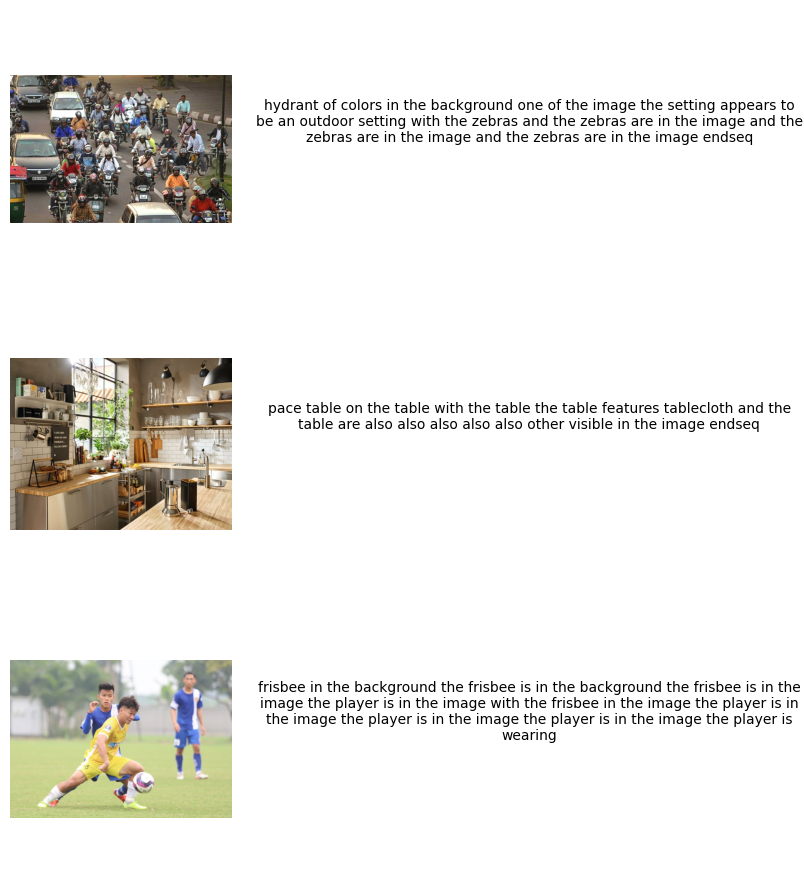

In [43]:
def generate_multiple_captions_beam_search(
    model, image_urls, tokenizer, max_length, beam_width=10, max_words=50
):
    fig, axes = plt.subplots(len(image_urls), 2, figsize=(8, 3 * len(image_urls)))
    
    for idx, url in enumerate(image_urls):
        try:
            # Đọc ảnh từ URL
            image = read_image_from_url(url)
            
            # Trích xuất đặc trưng từ ảnh
            feature = get_feature(url)
            
            # Dự đoán caption bằng beam search
            caption = predict_caption_beam_search(
                model, feature, tokenizer,
                max_length=max_length,
                beam_width=beam_width,
                max_words=max_words
            )
            
            # Hiển thị ảnh trên cột đầu tiên
            axes[idx, 0].imshow(image)
            axes[idx, 0].axis("off")
            
            # Hiển thị caption ở cột thứ hai
            axes[idx, 1].text(
                0.2, 0.6, caption,
                wrap=True,
                horizontalalignment="center",
                verticalalignment="center",
                fontsize=10,
                bbox=dict(facecolor="white", alpha=0.8, edgecolor="none")  # Nền trắng
            )
            axes[idx, 1].axis("off")
            
            # In caption ra console
            print(f"Image {idx + 1} caption:")
            print(caption)
            print("-" * 50)
        except Exception as e:
            print(f"Error processing image {url}: {str(e)}")
    
    # Tăng khoảng cách giữa các cột
    # plt.subplots_adjust(wspace=0.4, hspace=0.4)
    plt.subplots_adjust(hspace=0.4)
    plt.tight_layout()
    plt.show()

# Sử dụng hàm
image_urls = [
    "https://archive.indiaspend.com/wp-content/uploads/ROAD-ARTICLE2.jpg",
    "https://cdn.nguyenkimmall.com/images/companies/_1/Content/tin-tuc/gia-dung/4-yeu-to-giup-ban-so-huu-mau-nha-bep-dep-tien-dung-h1.jpg", 
    "https://thanhnien.mediacdn.vn/Uploaded/quangtuyen/2022_04_22/anh-5-1381.jpg"
]

# Gọi hàm với các tham số beam search
generate_multiple_captions_beam_search(
    model, 
    image_urls, 
    tokenizer, 
    max_length,
    beam_width=10,
    max_words=50
)

Image 1 caption:
game tennis ball on the right side of the image the man is in front of the image the man is in the image the man in the background the man is wearing white shirt and the player is wearing white shirt and the player is wearing white shirt and
--------------------------------------------------
Image 2 caption:
hydrant of colors in the background the scene appears to be in the background the scene appears to be an outdoor setting with trees in the image endseq
--------------------------------------------------
Image 3 caption:
hydrant in the background one of the image the setting appears to be in an outdoor setting with other people in the background the setting appears to be in the background the man is in the background the setting appears to be engaged in the background the man is wearing
--------------------------------------------------


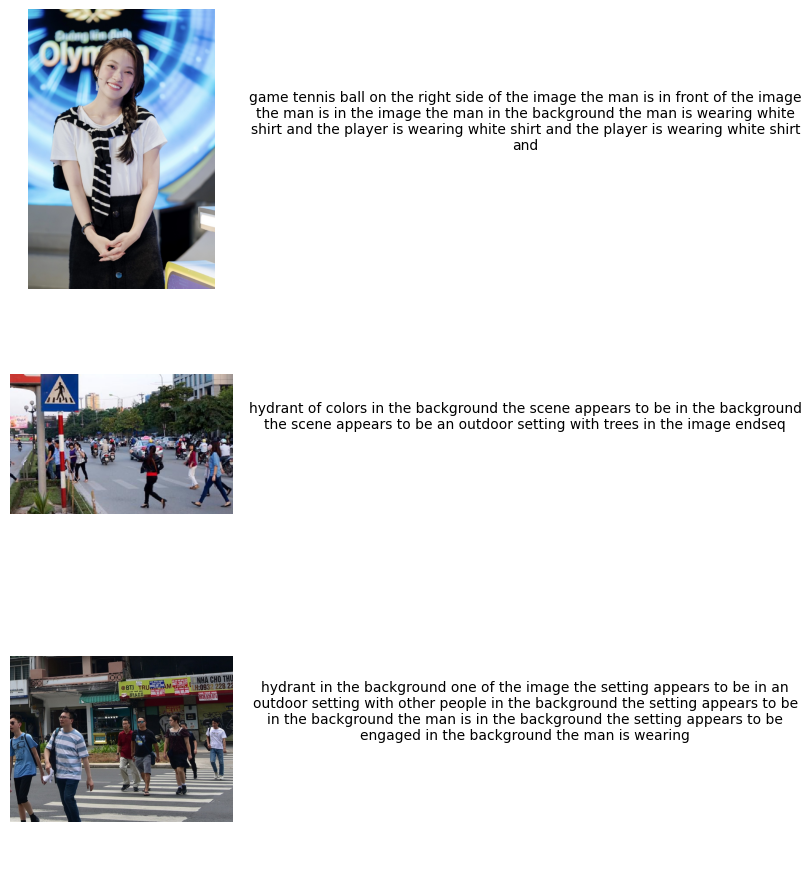

In [44]:
#People
image_urls = [
    "https://photo-cms-tpo.epicdn.me/w1000/Uploaded/2023/ofh-otmgxuzt/2023_04_11/325602109-5467446096694800-8109553908103404737-n-8614.jpg",
    "https://nld.mediacdn.vn/zoom/700_438/291774122806476800/2023/11/16/2-1700104753459836929099.png",
    "https://cdn.tuoitre.vn/zoom/700_525/471584752817336320/2023/11/10/duongleloi-q1-dukhach4-2050570-2read-only-1699630063251396177997-139-0-1186-2000-crop-1699630908614941602615.jpg",
]

# Gọi hàm với các tham số beam search
generate_multiple_captions_beam_search(
    model, 
    image_urls, 
    tokenizer, 
    max_length,
    beam_width=10,
    max_words=50
)

Image 1 caption:
uttered oven on the sink and the sink the sink is located on the right side of the image and the sink on the right side of the image the sink is on the right side of the image and the bathtub on the right side of the image the
--------------------------------------------------
Image 2 caption:
uttered oven on the sink and the sink on the sink the sink is located on the sink and the sink on the sink the sink is located on the sink of the sink and the toilet is located on the sink and the sink on the sink and the
--------------------------------------------------
Image 3 caption:
pace table with the sink and the other other the image appears to be in the image the setting appears to be in the image endseq
--------------------------------------------------


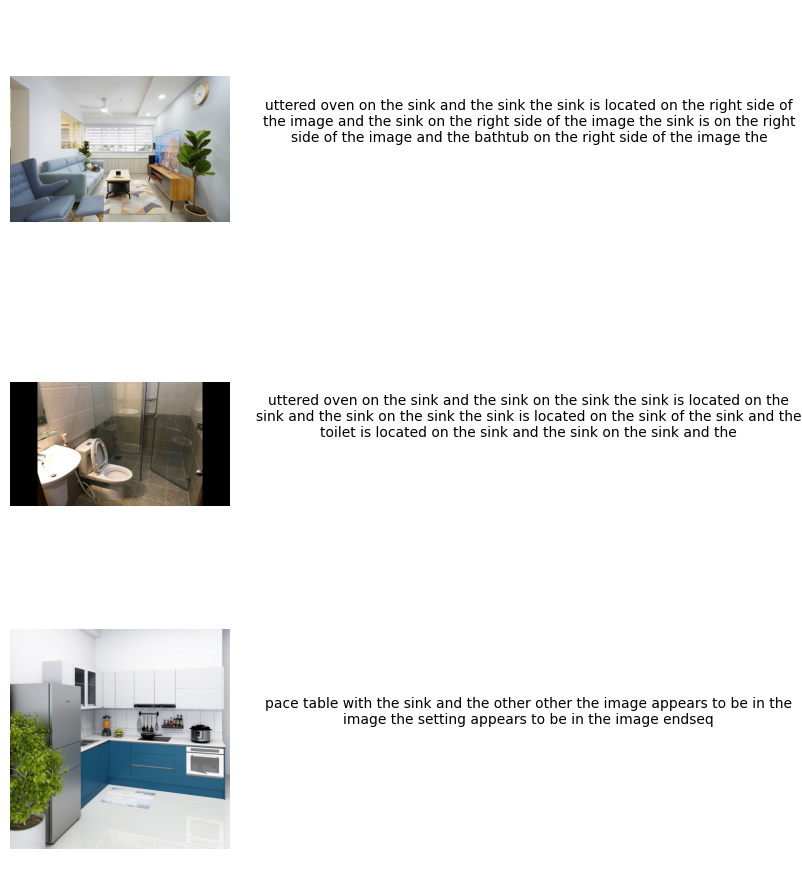

In [45]:
# Indoor
image_urls = [
    "https://katahome.com/wp-content/uploads/2021/11/thiet-ke-pk-chung-cu-nho-13.jpg",
    "https://i.ytimg.com/vi/1AW1hcssGro/maxresdefault.jpg",
    "https://file.hstatic.net/200000065946/file/pro_he_tu_bep_noi_that_moho_esstial_13_18f3ce906bf04a04a69086a0bc15812f_1024x1024.jpg",
]

# Gọi hàm với các tham số beam search
generate_multiple_captions_beam_search(
    model, 
    image_urls, 
    tokenizer, 
    max_length,
    beam_width=10,
    max_words=50
)

Image 1 caption:
hydra hydrant on the right side of the image the scene appears to be in the background the scene appears to be an urban setting with other people in the image endseq
--------------------------------------------------
Image 2 caption:
motorcycle motorcycle on the right side of the motorcycle and the motorcycle is on the right side of the image and the motorcycle is in the background the motorcycle is in the image with the motorcycle the motorcycle is on the right side of the image and the motorcycle is
--------------------------------------------------
Image 3 caption:
train train train train of the train train of the train the train is parked on the train of the train the train is on the right side of the train the train is on the right side of the train the train is on the right side of the
--------------------------------------------------


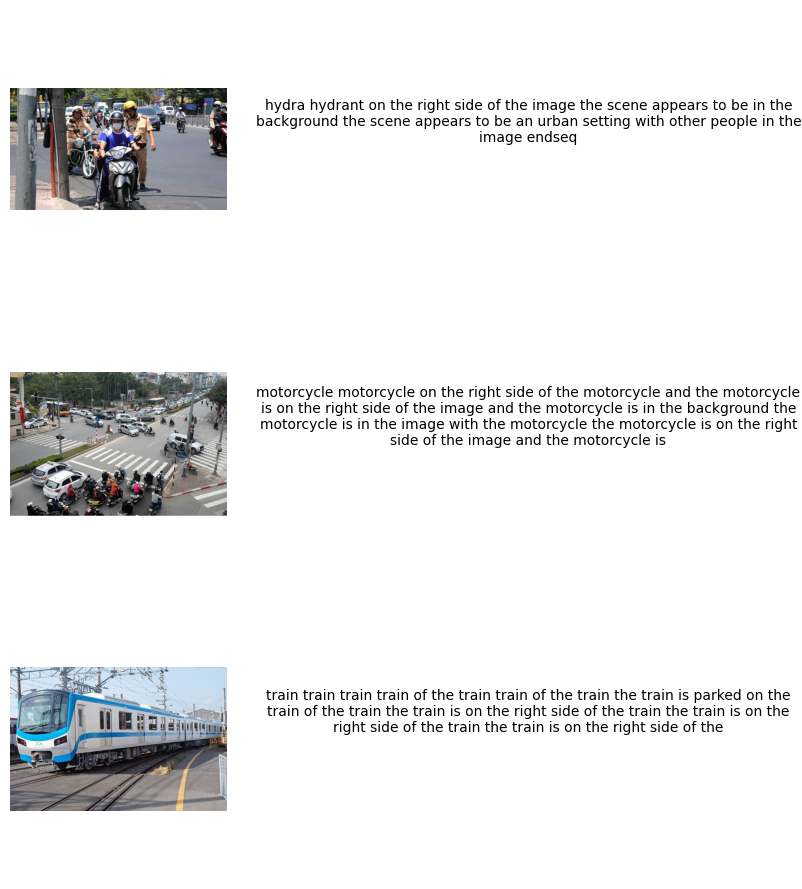

In [46]:
# Traffic
image_urls = [
    "https://cdn.baoquocte.vn/stores/news_dataimages/2024/112024/09/21/tp-ho-chi-minh-khong-nhan-giu-xe-may-hoc-sinh-chua-du-tuoi-chua-co-giay-phep-lai-xe-20241109211012.webp?rt=202411131007",
    "https://staticgthn.kinhtedothi.vn/zoom/868/uploaded/nhungtkts/2022_07_02/d4ba272351c8161a6701379dbe58da51_fvwj.png", # Giao thông
    "https://vnn-imgs-f.vgcloud.vn/2020/09/06/15/first-hcm-city-metro-train-set-for-vietnam.jpg",
]
# Gọi hàm với các tham số beam search
generate_multiple_captions_beam_search(
    model, 
    image_urls, 
    tokenizer, 
    max_length,
    beam_width=10,
    max_words=50
)

Image 1 caption:
dog dog in the background the dog appears to be in the background the dog appears to be in the background the dog appears to be in the background the dog appears to be in the background the dog the dog appears to be in the background the dog is
--------------------------------------------------
Image 2 caption:
surfer on surfboard on the wave the surfboard is on the surfboard on the surfboard on the surfboard is on the surfboard on the surfboard is on the surfboard on the surfboard is on the surfboard on the surfboard is on the surfboard on the surfboard and appears to be
--------------------------------------------------
Image 3 caption:
hydrant in the background the sheep are grazing in the image and the sheep are grazing in the image the zebras are grazing in the image and the zebras are grazing in the image and the zebras are grazing in the image and the zebra is in the image the
--------------------------------------------------


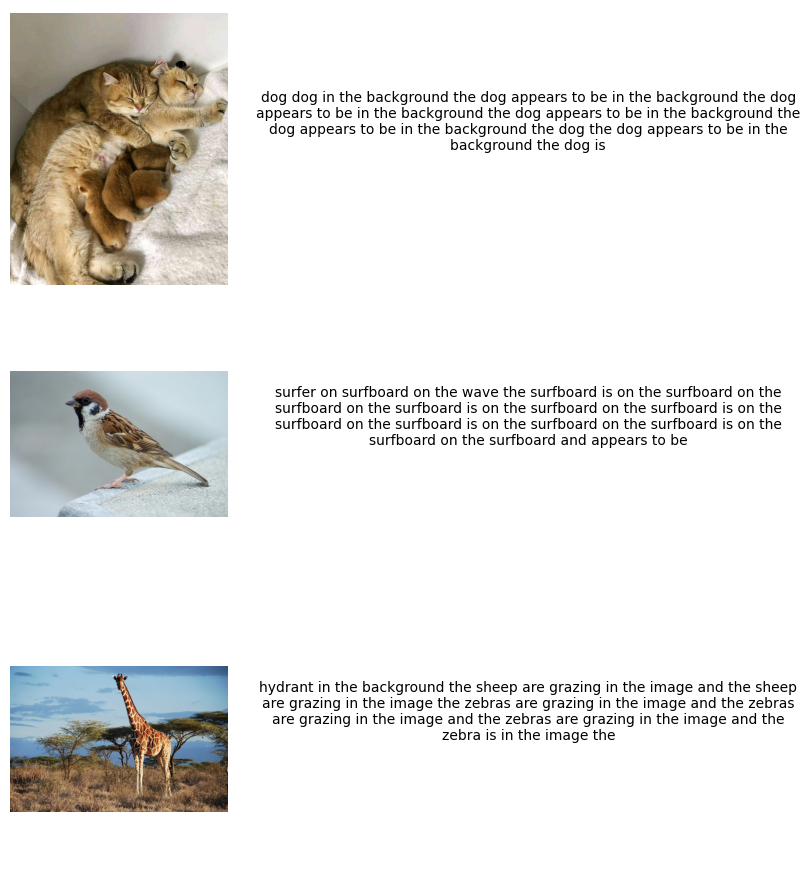

In [47]:
#Animal
image_urls = [
    "https://zshop.vn/blogs/wp-content/uploads/2023/02/607990c2c10d9_w91roa5s7qq61__700.jpg", # Động vật
    "https://vnn-imgs-f.vgcloud.vn/2019/12/31/14/bai-thuoc-tu-chim-se-chua-nam-gioi-liet-duong-it-tinh.jpg",
    "https://sohanews.sohacdn.com/160588918557773824/2022/6/6/photo-3-16544838276781358171014.jpg",
]
# Gọi hàm với các tham số beam search
generate_multiple_captions_beam_search(
    model, 
    image_urls, 
    tokenizer, 
    max_length,
    beam_width=10,
    max_words=50
)